In [48]:
from PIL import Image
from io import BytesIO 
from glob import glob
import pandas as pd
import os, cv2, pytesseract, webcolors , json 
from pandas import Series

In [3]:
def get_texts_written_on_the_image(image_location):
    image = cv2.imread(image_location)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))
    dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                    cv2.CHAIN_APPROX_NONE)
    im2 = image.copy()
    string_array = []
    for cnt in contours:
        # print("once")
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Drawing a rectangle on copied image
        rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Cropping the text block for giving input to OCR
        cropped = im2[y:y + h, x:x + w]
        text = pytesseract.image_to_string(cropped)
        string_array.append(text)
    clean_array = []
    for s in string_array:
        the_text = str(s).replace("\n" , " ").replace("\x0c", "").replace("  " , " ").strip()
        if the_text != "":
            clean_array.append(the_text)
    return clean_array

In [4]:
def get_dominant_colors(image_location):
    img = Image.open(image_location)

    def closest_colour(requested_colour):
        min_colours = {}
        for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(key)
            rd = (r_c - requested_colour[0]) ** 2
            gd = (g_c - requested_colour[1]) ** 2
            bd = (b_c - requested_colour[2]) ** 2
            min_colours[(rd + gd + bd)] = requested_colour
        return min_colours[min(min_colours.keys())]

    def top_colors(image, n):
        # convert the image to rgb
        image = image.convert('RGB')
        
        # resize the image to 300 x 300
        image = image.resize((300,300))
        
        detected_colors =[]
        for x in range(image.width):
            for y in range(image.height):
                detected_colors.append(closest_colour(image.getpixel((x,y))))
        Series_Colors = pd.Series(detected_colors)
        output=Series_Colors.value_counts()/len(Series_Colors)
        return(output.head(n))
    return top_colors(img,10)

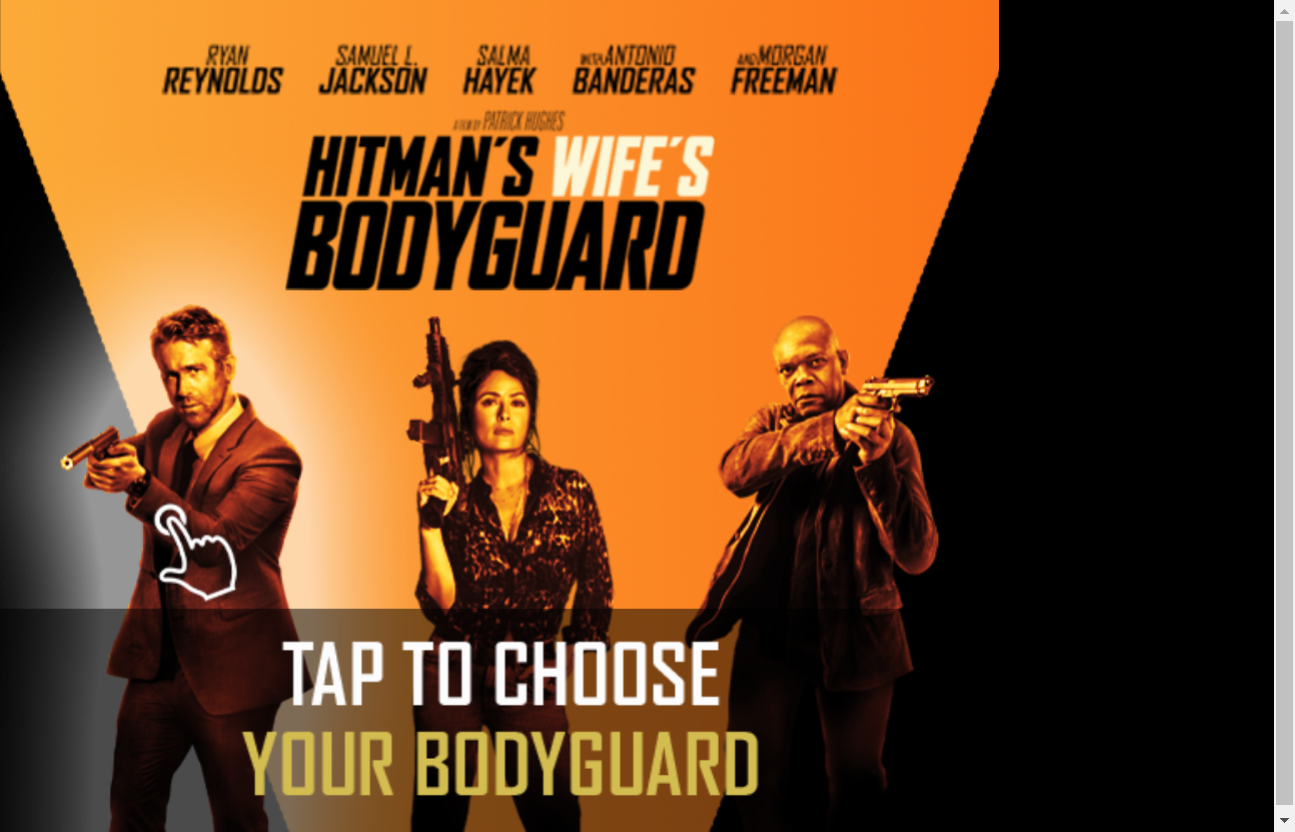

In [11]:
image_location  = '../data/Creative Assets_/adunit-hitmans-wifes-body-guard-user-choice-mpu-bc15bf6f3e07493399de.png'
img = Image.open(image_location)
img

### Text Extraction

In [12]:
get_texts_written_on_the_image(image_location)

["WIFE'S",
 'SAMUEL 1. JACKSON',
 'rvANTONIO BANDERAS',
 'SALMA HAYEK',
 "WIFE'S PTO CHOOSE"]

### Color Extraction

In [14]:
colors = get_dominant_colors(image_location)

In [18]:
color_list = colors.index.tolist()
color_list

[(0, 0, 0),
 (251, 130, 33),
 (251, 132, 34),
 (251, 122, 28),
 (251, 135, 36),
 (251, 128, 32),
 (251, 120, 27),
 (251, 134, 35),
 (251, 133, 35),
 (251, 123, 29)]

In [19]:
color_json = {}
for index , c in enumerate(color_list):
    color_json[f'{index}'] = {
        "red": c[0],
        "green": c[1],
        "blue": c[2]
    }
color_json

{'0': {'red': 0, 'green': 0, 'blue': 0},
 '1': {'red': 251, 'green': 130, 'blue': 33},
 '2': {'red': 251, 'green': 132, 'blue': 34},
 '3': {'red': 251, 'green': 122, 'blue': 28},
 '4': {'red': 251, 'green': 135, 'blue': 36},
 '5': {'red': 251, 'green': 128, 'blue': 32},
 '6': {'red': 251, 'green': 120, 'blue': 27},
 '7': {'red': 251, 'green': 134, 'blue': 35},
 '8': {'red': 251, 'green': 133, 'blue': 35},
 '9': {'red': 251, 'green': 123, 'blue': 29}}

#### Create a single image features in JSON 

In [20]:
imagename_array = image_location.split('/')
each_label_name = imagename_array[-1].split('-')
child_name = each_label_name[-1].split('.')[0]
parent_name = "-".join(each_label_name[:len(each_label_name)-1])
json_created = {
    f'{parent_name}': {
        f'{child_name}': {
            "text":{
                "engagement": get_texts_written_on_the_image(image_location),
                "click_through": get_dominant_colors(image_location)
            },
            "colors":{
              "engagement": color_json,
              "click_through": color_json
                    },
            "videos_data": {
                "has_video": 0
            },        
        }
        }
}

In [22]:
json_created

{'adunit-hitmans-wifes-body-guard-user-choice-mpu': {'bc15bf6f3e07493399de': {'text': {'engagement': ["WIFE'S",
     'SAMUEL 1. JACKSON',
     'rvANTONIO BANDERAS',
     'SALMA HAYEK',
     "WIFE'S PTO CHOOSE"],
    'click_through': (0, 0, 0)         0.289500
    (251, 130, 33)    0.007033
    (251, 132, 34)    0.006211
    (251, 122, 28)    0.005544
    (251, 135, 36)    0.005478
    (251, 128, 32)    0.005111
    (251, 120, 27)    0.005056
    (251, 134, 35)    0.005000
    (251, 133, 35)    0.004878
    (251, 123, 29)    0.004744
    Name: count, dtype: float64},
   'colors': {'engagement': {'0': {'red': 0, 'green': 0, 'blue': 0},
     '1': {'red': 251, 'green': 130, 'blue': 33},
     '2': {'red': 251, 'green': 132, 'blue': 34},
     '3': {'red': 251, 'green': 122, 'blue': 28},
     '4': {'red': 251, 'green': 135, 'blue': 36},
     '5': {'red': 251, 'green': 128, 'blue': 32},
     '6': {'red': 251, 'green': 120, 'blue': 27},
     '7': {'red': 251, 'green': 134, 'blue': 35},
     '8'

### Process Images in the Folder and generate the features to a JSON file

In [31]:
def get_texts_written_on_the_image(image_location):
    image = cv2.imread(image_location)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))
    dilation = cv2.dilate(thresh1, rect_kernel, iterations=1)
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    im2 = image.copy()
    string_array = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cropped = im2[y:y + h, x:x + w]
        text = pytesseract.image_to_string(cropped)
        string_array.append(text)
    clean_array = []
    for s in string_array:
        the_text = str(s).replace("\n", " ").replace("\x0c", "").replace("  ", " ").strip()
        if the_text != "":
            clean_array.append(the_text)
    return clean_array

In [32]:
def get_dominant_colors(image_location):
    img = Image.open(image_location)

    def closest_colour(requested_colour):
        min_colours = {}
        for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(key)
            rd = (r_c - requested_colour[0]) ** 2
            gd = (g_c - requested_colour[1]) ** 2
            bd = (b_c - requested_colour[2]) ** 2
            min_colours[(rd + gd + bd)] = requested_colour
        return min_colours[min(min_colours.keys())]

    def top_colors(image, n):
        image = image.convert('RGB')
        image = image.resize((300, 300))
        detected_colors = []
        for x in range(image.width):
            for y in range(image.height):
                detected_colors.append(closest_colour(image.getpixel((x, y))))
        Series_Colors = pd.Series(detected_colors)
        output = Series_Colors.value_counts() / len(Series_Colors)
        return output.head(n)
    
    return top_colors(img, 10)

In [33]:
def process_images_in_folder(image_folder_location):
    image_files = glob(os.path.join(image_folder_location, '*.png'))[:10]  # Get the first 10 PNG files in the folder
    
    all_image_data = []
    
    for image_location in image_files:
        # Extract text features from the image
        text_features = get_texts_written_on_the_image(image_location)
        
        # Extract color features from the image
        color_features = get_dominant_colors(image_location)
        
        # Extract image name
        imagename_array = image_location.split('/')
        each_label_name = imagename_array[-1].split('-')
        child_name = each_label_name[-1].split('.')[0]
        parent_name = "-".join(each_label_name[:len(each_label_name)-1])
        
        # Construct JSON data
        image_data = {
            parent_name: {
                child_name: {
                    "text": {
                        "engagement": text_features,
                        "click_through": color_features
                    },
                    "colors": {
                        "engagement": color_features,
                        "click_through": color_features
                    },
                    "videos_data": {
                        "has_video": 0
                    }
                }
            }
        }
        
        all_image_data.append(image_data)
    
    return all_image_data

In [34]:
# Define your image_folder_location
image_folder_location = '../data/Creative Assets_'

# Process images in the folder and get JSON data
image_data = process_images_in_folder(image_folder_location)

# Display the JSON data
for data in image_data:
    print(data)

{'Creative Assets_\\adunit-iwc-portugieser-physics-mob': {'d071433c0e09216d8f80': {'text': {'engagement': ['SCHAFFHAUSEN'], 'click_through': (0, 0, 0)          0.520000
(80, 96, 115)      0.004033
(213, 213, 213)    0.002967
(5, 5, 5)          0.002944
(193, 193, 193)    0.002933
(192, 192, 192)    0.002933
(196, 196, 196)    0.002933
(182, 182, 182)    0.002922
(9, 13, 22)        0.002133
(6, 10, 19)        0.001422
Name: count, dtype: float64}, 'colors': {'engagement': (0, 0, 0)          0.520000
(80, 96, 115)      0.004033
(213, 213, 213)    0.002967
(5, 5, 5)          0.002944
(193, 193, 193)    0.002933
(192, 192, 192)    0.002933
(196, 196, 196)    0.002933
(182, 182, 182)    0.002922
(9, 13, 22)        0.002133
(6, 10, 19)        0.001422
Name: count, dtype: float64, 'click_through': (0, 0, 0)          0.520000
(80, 96, 115)      0.004033
(213, 213, 213)    0.002967
(5, 5, 5)          0.002944
(193, 193, 193)    0.002933
(192, 192, 192)    0.002933
(196, 196, 196)    0.002933
(1

In [49]:
def convert_to_serializable(obj):
    if isinstance(obj, Series):
        # Convert Series to dictionary, ensuring tuples are converted to lists
        return {str(k): list(v) if isinstance(v, tuple) else v for k, v in obj.to_dict().items()}
    elif isinstance(obj, dict):
        return {str(k): convert_to_serializable(v) for k, v in obj.items()}  # Recursively convert dictionary values
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]  # Recursively convert list elements
    else:
        return obj  # Return the object unchanged if it's already serializable  

try:
    # Convert the data structure to JSON-serializable types
    serializable_image_data = convert_to_serializable(image_data)

    # Save the JSON data to a file
    output_file = '../data/image_features.json'
    with open(output_file, 'w') as f:
        json.dump(serializable_image_data, f, indent=4)

    print(f"JSON data saved to {output_file}")
except TypeError as e:
    print("Error occurred while serializing the data:")
    print(e)
    print("Problematic data:")
    print(image_data)


JSON data saved to ../data/image_features.json
